In [80]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import tensorflow as tf

In [84]:
! pip show tensorflow

Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\rambe\miniconda3\envs\face37\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [83]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [50]:
# Load face detection model
detector = MTCNN()

# Load face recognition model
facenet_model = load_model('./facenet_keras.h5')

# Load face embeddings
data = np.load('./embeddings/unmasked-embeddings.npz')
trainX, trainy = data['arr_0'], data['arr_1']

# Normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)

# Label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)

# Define the classes
class_names = out_encoder.classes_
class_names = np.append(class_names, 'unknown')

# Train SVM classifier
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [60]:
# Define function to extract face embeddings
def extract_face_embeddings(image):
    # Detect faces in the image
    faces = detector.detect_faces(image)
    if not faces:
        return None
    # Extract the first face only
    x1, y1, width, height = faces[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = image[y1:y2, x1:x2]
    # Resize face to the size required by facenet model
    face = cv2.resize(face, (160, 160))
    # Preprocess the face for facenet model
    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face - mean) / std
    face = np.expand_dims(face, axis=0)
    # Generate embeddings using facenet model
    embeddings = facenet_model.predict(face)
    return embeddings[0]

def reduce_features(embeddings, n_components=2):
    # Reduce the dimensionality of the embeddings
    # Embeddings is 1d array of shape (1, 128)
    pca = PCA(n_components=n_components)
    pca.fit(trainX)
    embeddings = pca.transform(embeddings)
    return embeddings

def normalize_embeddings(embeddings):
    # Normalize the embeddings
    embeddings = in_encoder.transform([embeddings])
    return embeddings

def get_new_embeddings(image):
    # Extract face embeddings from input image
    embeddings = extract_face_embeddings(image)
    if embeddings is None:
        return None
    # Normalize embeddings
    embeddings = normalize_embeddings(embeddings)
    # Reduce the dimensionality of the embeddings
    # embeddings = reduce_features(embeddings)
    return embeddings

# # Define function to identify the identity of an input image
def identify_person(image):
    # Extract face embeddings from input image
    embeddings = extract_face_embeddings(image)
    if embeddings is None:
        return None, None
    # Normalize embeddings
    embeddings = in_encoder.transform([embeddings])
    # Predict the identity and confidence using SVM classifier
    prediction = model.predict(embeddings)
    confidence = model.predict_proba(embeddings)[0][prediction] * 100
    prediction = out_encoder.inverse_transform(prediction)
    return prediction[0].item(), confidence

# Define function to identify the identity and confidence of an input image
def identify_person_with_unknown(image, threshold=0.9):
    # Extract face embeddings from input image
    embeddings = extract_face_embeddings(image)
    if embeddings is None:
        return None, None
    # Normalize embeddings
    embeddings = in_encoder.transform([embeddings])
    
    print(embeddings)
    
    # Predict the identity and confidence using SVM classifier
    predictions = model.predict_proba(embeddings)[0]
    max_idx = np.argmax(predictions)
    if predictions[max_idx] >= threshold:
        prediction = out_encoder.inverse_transform([max_idx])
        confidence = predictions[max_idx] * 100
        return prediction[0].item(), confidence
    else:
        return "unknown", None

In [71]:
IMAGE_DIR = 'images'
pos = {}

imgs = []

# read all folders in images
folders = os.listdir(IMAGE_DIR)
folders = [folder for folder in folders if os.path.isdir(os.path.join(IMAGE_DIR, folder))]
for folder in folders:
    image_names = os.listdir(os.path.join(IMAGE_DIR, folder))
    for image_name in image_names:
        name = os.path.join(IMAGE_DIR, folder, image_name)
        if (name.endswith('.jpg') or name.endswith('.png')):
            imgs.append(name)

# only use 3 images from img
imgs = imgs[:3]

for img in imgs:
    image = cv2.imread(img)
    embeddings = get_new_embeddings(image)
    if embeddings is None:
        print(f'No face detected in {img}!')
    else:
        pos[img] = embeddings.flatten()
            # Display the input image

1/1 [==============================] - 5s 5s/step


In [74]:
print(pos.keys())

dict_keys(['images\\08000\\08996.png', 'images\\12000\\12826.png', 'images\\28000\\28871.png'])


images\28000\28871.png


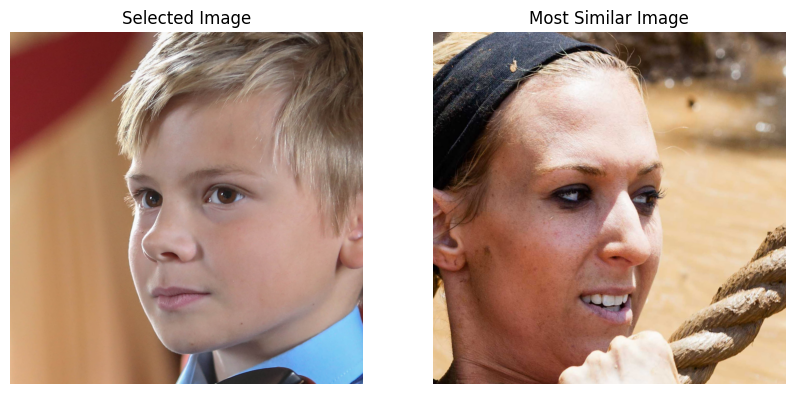

In [78]:
# pick a random image to display
image_name = np.random.choice(imgs)
print(image_name)
image_1 = cv2.imread(image_name)

# find the most similar image to the selected image

# calculate the cosine similarity between the selected image and all other images
similarities = {}
for image, embedding in pos.items():
    similarity = cosine_similarity([pos[image]], [pos[image_name]])[0][0]
    similarities[image] = similarity
    
# sort the similarities
similarities = dict(sorted(similarities.items(), key=lambda item: item[1], reverse=True))

# display the most similar image
most_similar_image_name = list(similarities.keys())[1]
most_similar_image = cv2.imread(most_similar_image_name)

# show both images side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Selected Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(most_similar_image, cv2.COLOR_BGR2RGB))
plt.title('Most Similar Image')
plt.axis('off')
plt.show()


